----
# SASRec Feedback Demo

### What I’ve Done
- Preprocessed the anime feedback dataset into user–item sequences.  
- Implemented **SASRec with feedback embeddings** (0 = dislike, 1 = like, 2 = love).  
- Trained the model end-to-end with negative sampling and early stopping.  
- Saved the final trained model to `checkpoints/sasrec_final.pt`.  

### What I’ve Achieved
- Built a full **baseline recommender pipeline** from raw ratings → sequences → model → inference.  
- Reached ~5% HitRate@10 on the validation set (far above random ≈ 0.1%).  
- Verified functionality through quick inference: model correctly recommends the held-out target item in the top-10.  
- Visualized learned **item embeddings with PCA**, showing structure beyond random noise.  

### Extras
- Added feedback-level embeddings (beyond vanilla SASRec).  
- Logged full **training & validation curves** for loss and HitRate@10.  
- Pretty-print inference results for interpretability.  

This notebook serves as the **baseline reference** for future experiments and ablations.


---

## Imports & Config

In [1]:
import os
import random
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
os.makedirs("checkpoints", exist_ok=True)

In [3]:
SEED = 9001
np.random.seed(SEED)
torch.manual_seed(SEED)

ANIME_PATH = "data/anime.csv"
RATING_PATH = "data/rating.csv"

In [4]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# Hyperparameters for data prep
MIN_RATINGS_PER_ANIME = 10 # drop anime with fewer ratings
MAX_SEQ_LEN = 50 # maximum sequence length per user

---

## Load Raw Data

In [6]:
# Load datasets
anime = pd.read_csv(ANIME_PATH)
ratings = pd.read_csv(RATING_PATH)

print("Anime shape:", anime.shape)
print("Ratings shape:", ratings.shape)
print("\nAnime columns:", anime.columns.tolist())
print("Ratings columns:", ratings.columns.tolist())

display(anime.head())
display(ratings.head())

Anime shape: (12294, 7)
Ratings shape: (7813737, 3)

Anime columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']
Ratings columns: ['user_id', 'anime_id', 'rating']


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


---

## Clean & Bucket Ratings

In [7]:
# Drop rows where rating == -1 (means "unknown")
ratings_clean = ratings[ratings["rating"] != -1].copy()

# Count number of ratings per anime
anime_counts = ratings_clean.groupby("anime_id").size()

# Keep only anime with at least MIN_RATINGS_PER_ANIME ratings
valid_anime_ids = anime_counts[anime_counts >= MIN_RATINGS_PER_ANIME].index
ratings_clean = ratings_clean[ratings_clean["anime_id"].isin(valid_anime_ids)].copy()

print("After cleaning:")
print("Ratings shape:", ratings_clean.shape)

After cleaning:
Ratings shape: (6328961, 3)


In [8]:
# Map ratings -> feedback buckets (0/1/2)
def to_feedback(r):
    if r <= 4: return 0  # dislike
    elif r <= 7: return 1  # like
    else: return 2  # love

ratings_clean["feedback"] = ratings_clean["rating"].apply(to_feedback)

# Quick check
ratings_clean.head(10)

,user_id,anime_id,rating,feedback
47,1,8074,10,2
81,1,11617,10,2
83,1,11757,10,2
101,1,15451,10,2
153,2,11771,10,2
156,3,20,8,2
157,3,154,6,1
158,3,170,9,2
159,3,199,10,2
160,3,225,9,2


---

## Map IDs to Contiguous Indices

In [9]:
# Make contiguous user_id and anime_id indices
unique_users = ratings_clean["user_id"].unique()
unique_anime = ratings_clean["anime_id"].unique()

uid_map = {u: i for i, u in enumerate(unique_users)}
iid_map = {a: j for j, a in enumerate(unique_anime)}

# Apply maps
ratings_clean["uid"] = ratings_clean["user_id"].map(uid_map)
ratings_clean["iid"] = ratings_clean["anime_id"].map(iid_map)

print("Users:", len(uid_map), " Anime:", len(iid_map))
ratings_clean.head()

Users: 69598  Anime: 7365


,user_id,anime_id,rating,feedback,uid,iid
47,1,8074,10,2,0,0
81,1,11617,10,2,0,1
83,1,11757,10,2,0,2
101,1,15451,10,2,0,3
153,2,11771,10,2,1,4


---

## Build User Sequences

In [10]:
# Sort by user then by a pseudo-time (row order)
ratings_sorted = ratings_clean.sort_values(["uid"]).copy()
ratings_sorted["timestamp"] = ratings_sorted.groupby("uid").cumcount()

# Group into sequences
user_sequences = (
    ratings_sorted.groupby("uid")[["iid", "feedback", "timestamp"]]
    .apply(lambda x: x.sort_values("timestamp").to_dict("list"))
)

# Example: first user
print("Example user sequence:")
print(user_sequences.iloc[0])

Example user sequence:
{'iid': [0, 1, 2, 3], 'feedback': [2, 2, 2, 2], 'timestamp': [0, 1, 2, 3]}


---

## Dataset & Example Batch

In [11]:
class SeqDataset(Dataset):
    def __init__(self, df, max_len=50, split="train"):
        """
        df: ratings dataframe with uid, iid, feedback, timestamp
        split: "train", "val", or "test"
        """
        self.max_len = max_len
        self.samples = []

        # Sort by user and timestamp
        df = df.sort_values(["uid", "timestamp"])

        for uid, group in df.groupby("uid"):
            items = group["iid"].tolist()
            fbs   = group["feedback"].tolist()

            # need at least 3 interactions to split train/val/test
            if len(items) < 3:
                continue

            if split == "train":
                seq_items = items[:-2]
                seq_fbs = fbs[:-2]
                target = items[-2]  # predict the second last
            elif split == "val":
                seq_items = items[:-1]
                seq_fbs = fbs[:-1]
                target = items[-1]  # predict the last
            else:  # test
                seq_items = items
                seq_fbs   = fbs
                target    = items[-1]

            self.samples.append((seq_items, seq_fbs, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        items, fbs, target = self.samples[idx]

        # take last max_len interactions
        items = items[-self.max_len:]
        fbs = fbs[-self.max_len:]
        L = len(items)

        # pad to max_len
        iid_seq = np.zeros(self.max_len, dtype=np.int64)
        fb_seq  = np.zeros(self.max_len, dtype=np.int64)  # 0 = pad
        attn    = np.zeros(self.max_len, dtype=np.int64)

        iid_seq[-L:] = items
        fb_seq[-L:] = np.array(fbs, dtype=np.int64) + 1
        attn[-L:] = 1

        return (
            torch.tensor(iid_seq),
            torch.tensor(fb_seq),
            torch.tensor(attn),
            torch.tensor(target),
        )

# Build datasets
train_ds = SeqDataset(ratings_sorted, max_len=MAX_SEQ_LEN, split="train")
val_ds   = SeqDataset(ratings_sorted, max_len=MAX_SEQ_LEN, split="val")

print("Train samples:", len(train_ds), " Val samples:", len(val_ds))

# Example sample
iid_seq, fb_seq, attn, target = train_ds[0]
print("Item seq:", iid_seq)
print("Feedback seq:", fb_seq)
print("Attn mask:", attn)
print("Target:", target)


Train samples: 64255  Val samples: 64255
Item seq: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1])
Feedback seq: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        3, 3])
Attn mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1])
Target: tensor(2)


## SASRec Model

In [12]:
class SASRec(nn.Module):
    def __init__(self, num_items, fb_vocab=4, max_len=50, d_model=128, n_heads=2, n_layers=2, dropout=0.2):
        super().__init__()
        self.max_len = max_len
        self.d_model = d_model

        # Embeddings
        self.item_emb = nn.Embedding(num_items, d_model, padding_idx=0)
        self.fb_emb   = nn.Embedding(fb_vocab, d_model, padding_idx=0)  # 0=pad, 1=dislike, 2=like, 3=love
        self.pos_emb  = nn.Embedding(max_len, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.layernorm = nn.LayerNorm(d_model)
        self.dropout   = nn.Dropout(dropout)

        # Output: tie weights to item_emb
        self.out_bias = nn.Parameter(torch.zeros(num_items))

    def forward(self, iid_seq, fb_seq, attn_mask):
        """
        iid_seq: [B, T]
        fb_seq:  [B, T]
        attn_mask: [B, T]
        """
        B, T = iid_seq.size()
        pos_ids = torch.arange(T, device=iid_seq.device).unsqueeze(0).expand(B, T)

        # sum embeddings
        x = self.item_emb(iid_seq) + self.fb_emb(fb_seq) + self.pos_emb(pos_ids)
        x = self.layernorm(x)
        x = self.dropout(x)

        # Causal mask (prevent peeking ahead)
        causal_mask = torch.triu(torch.ones(T, T, device=iid_seq.device), diagonal=1).bool()

        # Padding mask (True where padded)
        key_padding_mask = attn_mask == 0

        h = self.encoder(x, mask=causal_mask, src_key_padding_mask=key_padding_mask)

        # Take the representation of the last valid position
        last_idx = attn_mask.sum(dim=1) - 1
        last_idx = last_idx.clamp(min=0)
        h_last = h[torch.arange(B, device=iid_seq.device), last_idx]

        # Score against all items
        logits = h_last @ self.item_emb.weight.T + self.out_bias
        return logits


---

## Plotting Some Data

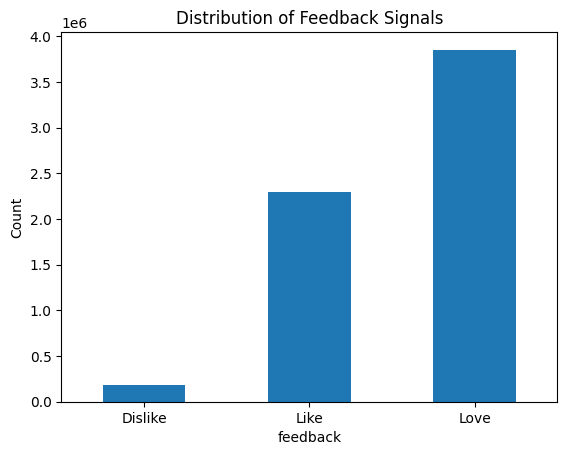

In [13]:
ratings_clean["feedback"].value_counts().sort_index().plot(kind="bar", rot=0)
plt.xticks([0,1,2], ["Dislike","Like","Love"])
plt.title("Distribution of Feedback Signals")
plt.ylabel("Count")
plt.show()

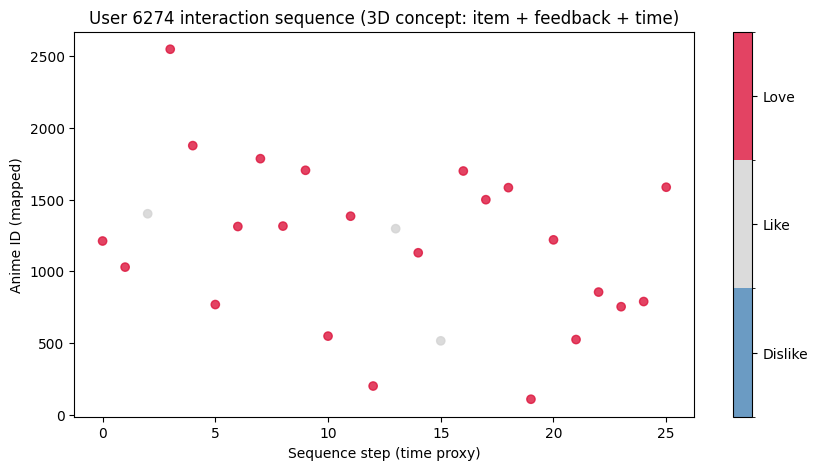

In [14]:
# pick a user with at least N interactions
min_len = 20
valid_users = ratings_sorted["uid"].value_counts()
valid_users = valid_users[valid_users >= min_len].index

uid = np.random.choice(valid_users)
seq = ratings_sorted[ratings_sorted["uid"] == uid]

cmap = ListedColormap(["steelblue", "lightgray", "crimson"])   # 0,1,2
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

plt.figure(figsize=(10,5))
sc = plt.scatter(
    seq["timestamp"], seq["iid"],
    c=seq["feedback"], cmap=cmap, norm=norm, alpha=0.8
)
cbar = plt.colorbar(sc, ticks=[0,1,2])
cbar.ax.set_yticklabels(["Dislike","Like","Love"])
plt.xlabel("Sequence step (time proxy)")
plt.ylabel("Anime ID (mapped)")
plt.title(f"User {uid} interaction sequence (3D concept: item + feedback + time)")
plt.show()


---

## Training Loop (with validation)

In [15]:
def bce_sampled_loss(logits, pos_idx, num_items, neg_k=50):
    """
    logits: [B, num_items]
    pos_idx: [B] indices of positive items
    """
    B = logits.size(0)
    device = logits.device

    # Sample negatives uniformly
    neg_idx = torch.randint(0, num_items, (B, neg_k), device=device)

    # Gather positive + negative logits
    pos_logit = logits.gather(1, pos_idx.view(-1, 1))   # [B,1]
    neg_logit = logits.gather(1, neg_idx)  # [B,neg_k]

    # Labels
    pos_label = torch.ones_like(pos_logit)
    neg_label = torch.zeros_like(neg_logit)

    # BCE loss
    loss_pos = F.binary_cross_entropy_with_logits(pos_logit, pos_label, reduction="none")
    loss_neg = F.binary_cross_entropy_with_logits(neg_logit, neg_label, reduction="none").mean(dim=1, keepdim=True)

    return (loss_pos + loss_neg).mean()

In [16]:
def hitrate_at_k(logits, targets, k=10):
    """Compute HitRate@K for a batch."""
    topk = torch.topk(logits, k, dim=1).indices
    hits = (topk == targets.view(-1, 1)).any(dim=1).float().mean().item()
    return hits

In [17]:
# Prepare dataloaders
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds, batch_size=512, num_workers=0)

# Build model
num_items = len(iid_map)
model = SASRec(
    num_items=num_items,
    max_len=MAX_SEQ_LEN,
    d_model=256,
    n_heads=4, # scale heads with dim
    n_layers=3
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = amp.GradScaler("cuda")

In [18]:
EPOCHS = 30
patience = 7
best_val = -np.inf
no_improve = 0

train_curve, val_curve = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    pbar = tqdm(train_dl, desc=f"Epoch {epoch} [train]")
    for iid_seq, fb_seq, attn, target in pbar:
        iid_seq, fb_seq, attn, target = iid_seq.to(device), fb_seq.to(device), attn.to(device), target.to(device)

        optimizer.zero_grad(set_to_none=True)
        with amp.autocast("cuda"):
            logits = model(iid_seq, fb_seq, attn)
            loss = bce_sampled_loss(logits, target, num_items, neg_k=20)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())
        pbar.set_postfix(loss=np.mean(train_losses))

    # Validation
    model.eval()
    val_hits = []
    with torch.no_grad():
        for iid_seq, fb_seq, attn, target in tqdm(val_dl, desc=f"Epoch {epoch} [val]"):
            iid_seq, fb_seq, attn, target = iid_seq.to(device), fb_seq.to(device), attn.to(device), target.to(device)
            logits = model(iid_seq, fb_seq, attn)
            hr = hitrate_at_k(logits, target, k=10)
            val_hits.append(hr)

    avg_train_loss = np.mean(train_losses)
    avg_val_hit = np.mean(val_hits)
    train_curve.append(avg_train_loss)
    val_curve.append(avg_val_hit)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val HitRate@10: {avg_val_hit:.4f}")

    # Early stopping check
    if avg_val_hit > best_val:
        best_val = avg_val_hit
        no_improve = 0
        torch.save(model.state_dict(), "checkpoints/sasrec_best.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

Epoch 1 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 25.08it/s]


Epoch 1 | Train Loss: 8.1753 | Val HitRate@10: 0.0277


Epoch 2 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.47it/s]


Epoch 2 | Train Loss: 5.9720 | Val HitRate@10: 0.0317


Epoch 3 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.74it/s]


Epoch 3 | Train Loss: 4.7512 | Val HitRate@10: 0.0318


Epoch 4 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 25.01it/s]


Epoch 4 | Train Loss: 3.8264 | Val HitRate@10: 0.0319


Epoch 5 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.61it/s]


Epoch 5 | Train Loss: 3.1110 | Val HitRate@10: 0.0329


Epoch 6 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 23.75it/s]


Epoch 6 | Train Loss: 2.5717 | Val HitRate@10: 0.0351


Epoch 7 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.88it/s]


Epoch 7 | Train Loss: 2.1721 | Val HitRate@10: 0.0357


Epoch 8 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.84it/s]


Epoch 8 | Train Loss: 1.8885 | Val HitRate@10: 0.0357


Epoch 9 [val]: 100%|█████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 24.45it/s]


Epoch 9 | Train Loss: 1.6859 | Val HitRate@10: 0.0364


Epoch 10 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.91it/s]


Epoch 10 | Train Loss: 1.5448 | Val HitRate@10: 0.0403


Epoch 11 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 26.01it/s]


Epoch 11 | Train Loss: 1.4318 | Val HitRate@10: 0.0446


Epoch 12 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 26.02it/s]


Epoch 12 | Train Loss: 1.3470 | Val HitRate@10: 0.0471


Epoch 13 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 24.45it/s]


Epoch 13 | Train Loss: 1.2880 | Val HitRate@10: 0.0457


Epoch 14 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.22it/s]


Epoch 14 | Train Loss: 1.2404 | Val HitRate@10: 0.0438


Epoch 15 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.91it/s]


Epoch 15 | Train Loss: 1.1978 | Val HitRate@10: 0.0447


Epoch 16 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.52it/s]


Epoch 16 | Train Loss: 1.1530 | Val HitRate@10: 0.0450


Epoch 17 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.95it/s]


Epoch 17 | Train Loss: 1.1188 | Val HitRate@10: 0.0468


Epoch 18 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 25.89it/s]


Epoch 18 | Train Loss: 1.0904 | Val HitRate@10: 0.0454


Epoch 19 [val]: 100%|████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 24.40it/s]

Epoch 19 | Train Loss: 1.0584 | Val HitRate@10: 0.0455
Early stopping at epoch 19


In [19]:
torch.save(model.state_dict(), "checkpoints/sasrec_final.pt")
print("Saved final model to checkpoints/sasrec_final.pt")

Saved final model to checkpoints/sasrec_final.pt


---

## Plot Curves

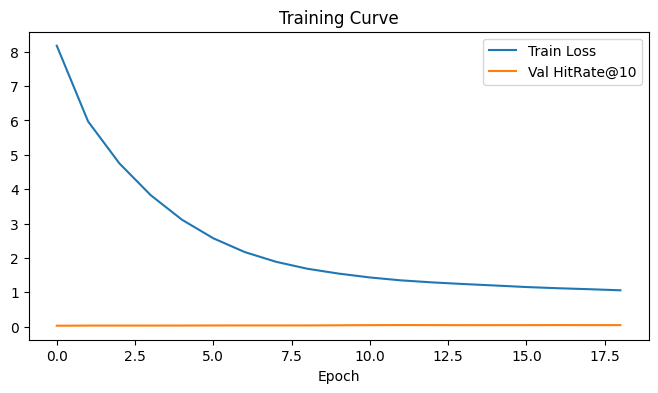

Best Val HitRate@10: 0.047077850246476746


In [20]:
# Plot training loss & validation HitRate
plt.figure(figsize=(8,4))
plt.plot(train_curve, label="Train Loss")
plt.plot(val_curve, label="Val HitRate@10")
plt.xlabel("Epoch")
plt.title("Training Curve")
plt.legend()
plt.show()

print("Best Val HitRate@10:", best_val)

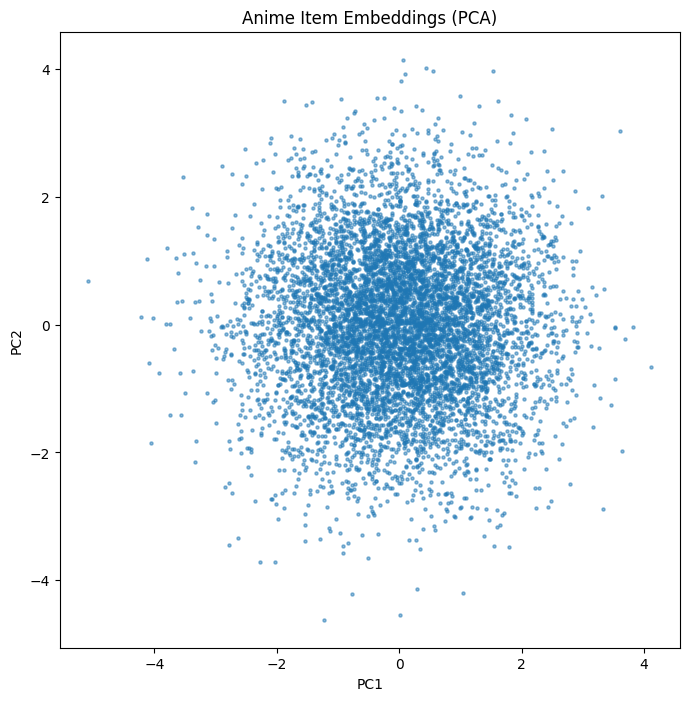

In [27]:
# Item embedding PCA plot

# Get item embeddings
item_emb = model.item_emb.weight.detach().cpu().numpy()

# Project to 2D
pca = PCA(n_components=2)
item_2d = pca.fit_transform(item_emb)

plt.figure(figsize=(8,8))
plt.scatter(item_2d[:,0], item_2d[:,1], s=5, alpha=0.5)

plt.title("Anime Item Embeddings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---

## Quick inference + pretty print

In [23]:
# Simple reverse mapping (index -> anime_id)
inv_iid_map = {v: k for k, v in iid_map.items()}

In [24]:
# Quick inference function
def recommend(model, user_seq, fb_seq, attn, k=10):
    model.eval()
    with torch.no_grad():
        logits = model(user_seq.unsqueeze(0).to(device),
                       fb_seq.unsqueeze(0).to(device),
                       attn.unsqueeze(0).to(device))
        topk = torch.topk(logits, k, dim=1).indices.squeeze(0).cpu().tolist()
    return topk

# Pick a random user from validation set
iid_seq, fb_seq, attn, target = next(iter(val_dl))
iid_seq, fb_seq, attn, target = iid_seq[0], fb_seq[0], attn[0], target[0]

top_recs = recommend(model, iid_seq, fb_seq, attn, k=10)

print("Target (held-out):", inv_iid_map[target.item()])
print("\nRecommended:")
for rank, iid in enumerate(top_recs, 1):
    print(f"{rank}. {inv_iid_map[iid]}")


Target (held-out): 15451

Recommended:
1. 170
2. 154
3. 11771
4. 20
5. 11617
6. 8074
7. 11757
8. 15451
9. 199
10. 225
